In [ ]:
from rocketpy import Rocket, Environment, Flight, LiquidMotor, Fluid, CylindricalTank, MassFlowRateBasedTank, MassBasedTank
from math import exp
from datetime import datetime, timedelta
from CoolProp.CoolProp import PropsSI
import numpy as np

In [ ]:
#Far-out
tomorrow = datetime.now() + timedelta(days=1)
env = Environment(
    date=tomorrow,  
    latitude=35.35,
    longitude=-117.81, # Far-out not precise
)
env.set_elevation("Open-Elevation")
env.set_atmospheric_model(type="forecast", file="GFS")
env.max_expected_height = 10000
env.plots.atmospheric_model()

env.info()

In [ ]:
# Stałe dla turbulencji
external_tank_diameter = 0.2
tank_height = 1.13
thickness_tank = 0.005
thickness_piston = 0.01

# Parametry, które potrzebuję
p_0 = 63e5 #ciśnienie początkowe
piston_position = 0.85
total_oxidizer_mass = 18
flux_time = 11.2
# csv z masą utleniacza i paliwa w czasie
ethanol_temperature = 300
# Parametry, które zakładem
gas_initial_mass_fuel = 0

# Parametry, które wyliczam
N20_liq_density = PropsSI("D", "P", p_0, "Q", 0, "NitrousOxide")
N20_gas_density = PropsSI("D", "P", p_0, "Q", 1, "NitrousOxide")
ethanol_liq_density = PropsSI("D", "P", p_0-1e5, "T", ethanol_temperature, "Ethanol") # PropSI pokazuje 63e5 powyżej krytycznego, dlatego odejmuję
ethanol_gas_density = PropsSI("D", "P", p_0-1e5, "Q", 1, "Ethanol")

volume_tank = 0.25*np.pi*(external_tank_diameter-2*thickness_tank)**2*tank_height
volume_piston = 0.25*np.pi*(external_tank_diameter-2*thickness_tank)**2*thickness_piston
volume_oxidizer = piston_position*volume_tank
volume_fuel = volume_tank - volume_oxidizer - volume_piston

gas_initial_mass_ox = (volume_oxidizer - (total_oxidizer_mass / N20_liq_density)) / (1/N20_gas_density - 1/N20_liq_density)
liquid_initial_mass_ox = total_oxidizer_mass - gas_initial_mass_ox
liquid_initial_mass_fuel = volume_fuel * ethanol_liq_density

# Parametry stricte pod tank_geometry
tank_radius = (external_tank_diameter - 2*thickness_tank) / 2
adjusted_height_ox = piston_position*tank_height
adjusted_height_fuel = tank_height - adjusted_height_ox - thickness_piston

# Dla sprawdzenia czy wychodzi mi to samo co volume_oxidizer i volume_fuel
fuel_tank_volume = np.pi * tank_radius**2 * adjusted_height_fuel
oxidizer_tank_volume = np.pi * tank_radius**2 * adjusted_height_ox

In [ ]:
# Defining fluids
print(f"N2O liquid density: {N20_liq_density} kg/m^3")
print(f"N2O gas density: {N20_gas_density} kg/m^3")
print(f"Ethanol liquid density: {ethanol_liq_density} kg/m^3")
print(f"Ethanol gas density: {ethanol_gas_density} kg/m^3")

oxidizer_liq = Fluid(name="N2O_l", density=N20_liq_density)
oxidizer_gas = Fluid(name="N2O_g", density=N20_gas_density)
fuel_liq = Fluid(name="ethanol_l", density=ethanol_liq_density) 
fuel_gas = Fluid(name="ethanol_g", density=ethanol_gas_density)

In [ ]:
print(f"Total tank volume: {volume_tank} m^3")
print(f"Volume occupied by the piston: {volume_piston} m^3")
print(f"Volume of oxidizer: {volume_oxidizer} m^3")
print(f"Volume of fuel: {volume_fuel} m^3")
print(f"Initial mass of oxidizer gas: {gas_initial_mass_ox} kg")
print(f"Initial mass of oxidizer liquid: {liquid_initial_mass_ox} kg")
print(f"Fuel mass: {liquid_initial_mass_fuel} kg")
print(f"Adjusted height of oxidizer tank: {adjusted_height_ox} m")
print(f"Adjusted height of fuel tank: {adjusted_height_fuel} m")
print(f"Fuel tank volume: {fuel_tank_volume} m^3")
print(f"Oxidizer tank volume: {oxidizer_tank_volume} m^3")

In [ ]:
# Tank geometry
oxidizer_tank_geometry = CylindricalTank(
    radius=tank_radius,
    height=adjusted_height_ox,
)
fuel_tank_geometry = CylindricalTank(
    radius=tank_radius,
    height=adjusted_height_fuel,
)

In [ ]:
# Define tanks
mass_flow_rate_liq = round(liquid_initial_mass_ox/flux_time, 2) - 0.005 # waiting for csv
mass_flow_rate_gas = round(gas_initial_mass_ox/flux_time - 0.005, 2) # waiting for csv

oxidizer_tank = MassFlowRateBasedTank(
    name="oxidizer tank",
    geometry=oxidizer_tank_geometry,
    flux_time=flux_time, 
    initial_liquid_mass=liquid_initial_mass_ox, 
    initial_gas_mass=gas_initial_mass_ox,
    liquid_mass_flow_rate_in=0,
    liquid_mass_flow_rate_out=mass_flow_rate_liq, 
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out=mass_flow_rate_gas, 
    liquid=oxidizer_liq,
    gas=oxidizer_gas,
)


In [ ]:
#mass based tank 
gas_mass_function_ox = oxidizer_tank.gas_mass
liq_mass_function_ox = oxidizer_tank.liquid_mass
mass_based_oxidizer_tank = MassBasedTank(
    name="mass based oxidizer tank",
    geometry=oxidizer_tank_geometry,
    flux_time=flux_time,
    gas=oxidizer_gas,
    liquid=oxidizer_liq,
    gas_mass=gas_mass_function_ox,
    liquid_mass=liq_mass_function_ox,
    discretize=100,
)


In [ ]:
oxidizer_tank.all_info()
mass_based_oxidizer_tank.all_info()

In [ ]:
#Fuel tank
fuel_mass_flow_rate = liquid_initial_mass_fuel / flux_time - 0.01
fuel_tank = MassFlowRateBasedTank(
    name="fuel tank",
    geometry=fuel_tank_geometry,
    flux_time=flux_time,
    initial_liquid_mass=liquid_initial_mass_fuel-0.00001, #Same as above, only guess
    initial_gas_mass=gas_initial_mass_fuel,
    liquid_mass_flow_rate_in=0,
    liquid_mass_flow_rate_out=fuel_mass_flow_rate, #heuristics
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out=0,
    liquid=fuel_liq,
    gas=fuel_gas,
)

In [ ]:
#mass based tank
gas_mass_function_fuel = fuel_tank.gas_mass
liq_mass_function_fuel = fuel_tank.liquid_mass
mass_based_fuel_tank = MassBasedTank(
    name="mass based fuel tank",
    geometry=fuel_tank_geometry,
    flux_time=flux_time,
    gas=fuel_gas,
    liquid=fuel_liq,
    gas_mass=gas_mass_function_fuel,
    liquid_mass=liq_mass_function_fuel,
    discretize=100,
)

In [ ]:
fuel_tank.all_info()
mass_based_fuel_tank.all_info()

In [ ]:
z4000 = LiquidMotor(
    thrust_source=".\\data\\AGH-SS_Z4000-10sBurn-optimal.eng", #From tests
    dry_mass=2.7,
    dry_inertia=(0.02143, 0.02143, 0.005535), #This should be calculated using CAD, here I use estimations
    nozzle_radius=0.036, #From technical report
    center_of_dry_mass_position=0.144, #Estimated from openrocket
    nozzle_position=0,
    burn_time=14.4,
    coordinate_system_orientation="nozzle_to_combustion_chamber",
)
z4000.add_tank(tank=oxidizer_tank, position=1.285) #From nozzle to center of the tank
z4000.add_tank(tank=fuel_tank, position=2.01)
z4000.all_info()

In [ ]:
trb = Rocket(
    radius=0.1,
    mass=58.367, 
    inertia=(75.502, 75.502, 0.43), 
    power_off_drag=".\\data\\powerondrag.csv",  
    power_on_drag='.\\data\\powerondrag.csv',
    center_of_mass_without_motor=2.75, 
    coordinate_system_orientation="nose_to_tail", 
)
trb.add_motor(z4000, position=4.49)
trb.all_info()

In [ ]:
#Aerodynamic surfaces taken from openrocket
nose_cone = trb.add_nose(
    length=0.7, kind="lvhaack", position=0
)

fin_set = trb.add_trapezoidal_fins(
    n=4,
    root_chord=0.287,
    tip_chord=0.059,
    span=0.202,
    sweep_length=0.228,
    position=4.21,
    cant_angle=0,
)

tail = trb.add_tail(
    top_radius=0.1, bottom_radius=0.065, length=0.287, position=4.21
)

rail_buttons = trb.set_rail_buttons(
    upper_button_position=2.17, #Just some value, not accurate
    lower_button_position=3.5, #Just some value, not accurate
    angular_position=0, #Just some value, not accurate #0 stopni
)

main = trb.add_parachute(
    name="main",
    cd_s=12.72, # cd * parachute area
    trigger=1000,      
    sampling_rate=105,
    lag=6,
    noise=(0, 8.3, 0.5),
    radius=2.25, 
    height=2.25,
    porosity=0.0432,
)

drogue = trb.add_parachute(
    name="drogue",
    cd_s=1.218,
    trigger="apogee", 
    sampling_rate=105,
    lag=1,
    noise=(0, 8.3, 0.5),
    radius=0.76,
    height=0.76,
    porosity=0.0432,
)

trb.draw()
trb.plots.drag_curves()

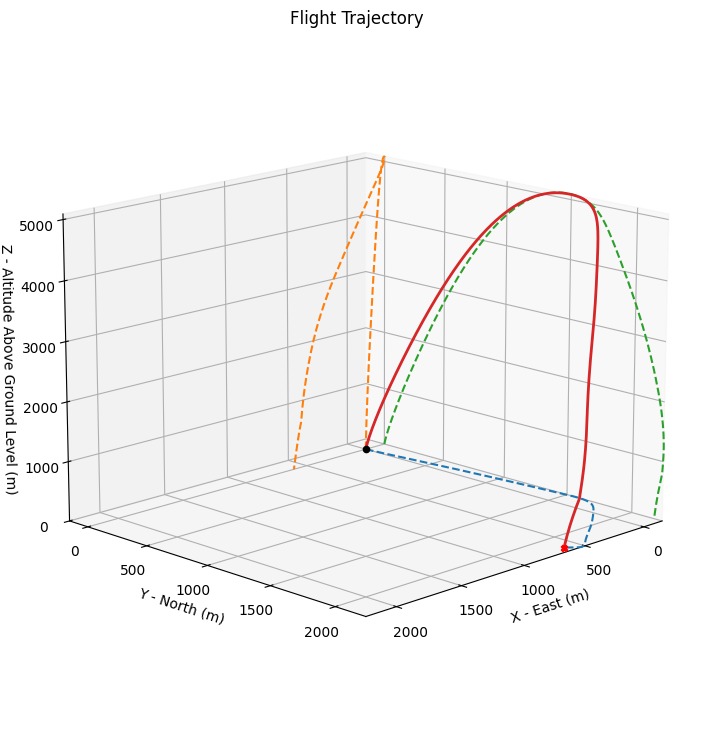

In [ ]:
test_flight = Flight(
    rocket=trb, environment=env, rail_length=15.24, inclination=85, heading=0
    )

# trb.all_info()
# test_flight.all_info()
test_flight.plots.trajectory_3d()
